# BESKRIVELSE AF MARKEDSSIMULATOREN

# Agent-baseret simulation af et marked med monopolistisk konkurrence

Runde- og agent-baseret simulation af adfærden på et marked med monopolistisk konkurrence. Monopolistisk konkurrence vil sige, at hver producent på markedet har mulighed for at sætte sin egen pris for sine varer, men vil opleve en varierende efterspørgsel og profit som følge af dette.

Hver agent svarer til en enkelt producent på markedet. Hver agent skal i hver runde tage beslutning om hvor mange varer der skal produceres, samt hvilken pris agenten vil tage for varerne. Simulationen beregner derefter gennemsnitsprisen på markedet, samt hvor stor efterspørgsel der vil være efter hver producents vare i den enkelte runde. 

Der er to typer af agenter, og de reagerer på forskellig måde på information om gennemsnitsprisen på markedet, egen profit og efterspørgslen efter egne varer i tidligere runder: 

- Herding agenter er pristagere - de følger flokken og justerer deres egen pris i retning mod gennemsnitsprisen på markedet. De justerer deres produktion i retning af den efterspørgsel de selv oplevede i forrige runde.

- Profit-seeking agenter justerer deres priser i den retning som de forventer giver mere profit, baseret på deres erfaring fra de to sidste runder. De laver kvalificerede gæt på hvor store mængder de bør producere i forhold til den pris de selv sætter og gennemsnitsprisen på markedet.

Markedssimulatoren er lavet af Christian Langholz Carstensen, Martin Dybdal og Niels Jensen. Den er baseret på artiklen "PQ strategies in monopolistic competition", Assenza et al., Journal of Economic Dynamics & Control 50 (2015). 



### Eksempler på eksperimenter man kan lave med simulatoren
1) Prøv at justere værdien af en eller flere af markedsparametrene og se hvordan agenterne nu søger mod en ny ligevægt på markedet. Undersøg f.eks. betydningen af en ændring i produktionsomkostningerne (c) eller det grundlæggende efterspørgselsniveau (e). Du kan også undersøge betydningen af graden af konkurrence på markedet (k).

2) Prøv at justere en eller flere af agenternes opsætningsparametre og undersøg betydningen for grafernes forløb. Undersøg f.eks. om andelen af herding agenter har betydning for hvor hurtigt markedet søger mod ligevægt. 

3) Prøv at justere agenternes markedsadfærd ved at ændre i deres adfærdsparametre. Dette er dog ikke for begyndere og forklares i en separat video i undervisningsforløbet på "Dataekspeditioners" hjemmeside.







 
# INPUT TIL MARKEDSSIMULATOREN
I denne del af koden kan man ændre parametre for hele markedet og for de enkelte agenter. 

## Først importeres de nødvendige biblioteker:

In [1]:
import matplotlib 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)
import pandas as pd
import numpy as np
import math
import importlib
import marketlib
importlib.reload(marketlib);



# Markedsparametre
## Bestemmer kendetegnene for det marked som agenterne skal navigere i


In [2]:
# Hvor mange runder skal simulationen køre?
time_steps = 200


# PRODUKTIONSOMKOSTNINGER
# c: Marginale produktionsomkostninger, dvs. omkostningerne ved at producere en enkelt vare.
# En ændring i c vil føre til en forskydning af udbudskurven.

c = 8


# EFTERSPØRGSEL
# e: Grundlæggende efterspørgsel, dvs. hvor stor er efterspørgslen efter producentens vare 
# hvis både salgsprisen og gennemsnitsprisen på markedet er 0 kr.?
# En ændring i e vil føre til en forskydning af efterspørgselskurven.

e = 105


# f: Prisfølsomhed, dvs. hvor meget falder efterspørgslen efter producentens vare 
# hvis både salgsprisen og gennemsnitsprisen på markedet stiger med 1 kr.?
# En ændring i f vil føre til en ændring i hældningen af efterspørgselskurven.

f = 2.92


# KONKURRENCEFORHOLD
# k: Konkurrencefølsomhed, dvs. hvor meget ændres efterspørgslen efter producentens vare 
# hvis salgsprisen afviger med 1 kr. fra gennemsnitsprisen på markedet?
# k = 0 svarer til ingen reel konkurrence, dvs. monopol-lignende forhold for den enkelte producent.
# k = 100 vil være tæt på fuldkommen konkurrence.

k = 14.58




####################### Beregning af markedsparametre. Her skal du IKKE ændre noget! #######################

alpha = e
beta = f+k
theta = k

# Saml model parametre 
mp = {'alpha': alpha, 'beta': beta, 'theta': theta, 'c': c}


# Agent parametre - opsætning
## Bestemmer agenternes antal, startværdier og type når simulationen starter

In [3]:
# Antal agenter
num_agents = 100


# Angiv andel af agenterne, der følger flokken i prissætning ("herding")
share_herding = 0.50


# Hvor mange penge har hver agent når simulationen går i gang?
initial_endowment = 5000


# Hvilket gennemsnitligt produktionsniveau starter agenterne på? 
initial_production_avg = 50


# Hvilken gennemsnitlig pris sætter agenterne i starten?
initial_price_avg = 15


# Hvor stor spredning skal der være i agenternes startværdier for produktion og pris?
# 0.0 = ingen spredning, alle agenter starter med samme produktion og pris
# 1.0 = max spredning
std_scale = 0.1


####################### Beregning af agentparametre. Her skal du IKKE ændre noget! #######################

num_agents_herding = int(share_herding*num_agents)
num_agents_profit_seeking = num_agents - num_agents_herding

prod_std = std_scale*initial_production_avg
initial_production = np.random.uniform(low = initial_production_avg - prod_std, high = initial_production_avg + prod_std, size = num_agents)

p_std = std_scale*initial_price_avg
initial_price = np.random.uniform(low = initial_price_avg - p_std, high = initial_price_avg + p_std, size = num_agents)


# Agent parametre - adfærd

## Bestemmer markedsadfærden for agenterne i løbet af simulationen
Her bør man ikke lave ændringer før man har set den tilhørende video i undervisningsforløbet på "Dataekspeditioners" hjemmeside eller har læst artiklen "PQ strategies in monopolistic competition", Assenza et al., Journal of Economic Dynamics & Control 50 (2015).

In [4]:
# Standardafvigelser på fejlled/chok i hhv. forventninger (epsilon), prissætning (u), mængder (eta)
# Anvendes i create_agents()
std_epsilon = 0.00
std_u = 0.08
std_eta = 0.08


# PROFIT SEEKING AGENTER
# Ved at justere tallene herunder, justerer man agenternes adfærd

pe_means_profit_seeking = {"c": 0.0,
                        "alpha_1": 1.0,
                        "alpha_2": 0.0,
                        "alpha_3": 0.0}

p_means_profit_seeking = {"c": 0, 
                        "beta_1": 1.0, 
                        "beta_2": 0.0,
                        "beta_3": 0.9, 
                        "beta_4": 0.0, 
                        "diff_pi": 0.0, 
                        "diff_p": 0.0}

q_means_profit_seeking = {
                        "c": mp['alpha'], 
                        "gamma_1": 0.0, 
                        "gamma_2": -mp['beta'], 
                        "gamma_3": mp['theta'], 
                        "gamma_4": 0.0}


# std_scale standardafvigelsen på agentparametrene som ratio ift parametrenes værdi. Dvs std = std_scale * parameter, mean = parameter
std_scale_profit_seeking = 0.00

# Gem parametre til agenters adfærd - profit seeking
pe_params_br, p_params_br, q_params_br, num_agents_profit_seeking = marketlib.get_parameters(mp,
                                                                            agent_type = "profit_seeking",
                                                                            num_agents = num_agents_profit_seeking,
                                                                            std_scale = std_scale_profit_seeking,
                                                                            pe_means = pe_means_profit_seeking,
                                                                            p_means = p_means_profit_seeking,
                                                                            q_means = q_means_profit_seeking)

# HERDING AGENTER
# Ved at justere tallene herunder, justerer man agenternes adfærd

pe_means_herding = {"c": 0.0,
                        "alpha_1": 1.0,
                        "alpha_2": 0.0,
                        "alpha_3": 0.0}

p_means_herding = {"c": 0, 
                        "beta_1": 0.5, 
                        "beta_2": 0.5, 
                        "beta_3": 0.0, 
                        "beta_4": 0.0, 
                        "diff_pi": 0.0, 
                        "diff_p": 0.0}

q_means_herding = {
                        "c": 0.0,
                        "gamma_1": 1.0, 
                        "gamma_2": 0.0, 
                        "gamma_3": 0.0, 
                        "gamma_4": -0.2}

# std_scale standardafvigelsen på agentparametrene som ratio ift parametrenes værdi. Dvs std = std_scale * parameter, mean = parameter
std_scale_herding = 0.00

# Gem parametre til agenters adfærd - herding
pe_params_h, p_params_h, q_params_h, num_agents_herding = marketlib.get_parameters(mp,
                                                                            agent_type = "herding",
                                                                            num_agents = num_agents_herding,
                                                                            std_scale = std_scale_herding,
                                                                            pe_means = pe_means_herding,
                                                                            p_means = p_means_herding,
                                                                            q_means = q_means_herding)


# Saml profit seeking parametre og herding parametre i 1 data frame for hver parameter klasse
pe_params = pd.concat([pe_params_br, pe_params_h], ignore_index=True)
p_params = pd.concat([p_params_br, p_params_h], ignore_index=True)
q_params = pd.concat([q_params_br, q_params_h], ignore_index=True)

#pe_params.reset_index(drop = True);
#p_params.reset_index(drop = True);
#q_params.reset_index(drop = True);


# KØRSEL AF SIMULATIONEN
Denne del af koden tager det givne input og bruger det til at køre simulationen af efterspørgslen på markedet samt agenternes adfærd i det antal runder som er angivet.



## Beregning af efterspørgsel

Efterspørgsels-funktionen for markedet

In [5]:
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

## Opret agenterne

In [6]:
def create_agents(n):
    # Tom liste af agenter
    agents = []

    # Opret så mange agenter vi har brug for
    # og gem dem i listen
    for i in range(n):
        agent = marketlib.Producer(initial_price[i],
                                   initial_production[i],
                                   initial_endowment,
                                   c = c,
                                   pe = pe_params.iloc[i],
                                   p = p_params.iloc[i],
                                   q = q_params.iloc[i],
                                   epsilon = std_epsilon,
                                   u = std_u,
                                   eta = std_eta)
        agents.append(agent)
    return agents

## Beskriv ét trin af simulationen

In [7]:
def simulation_step(agents, t, mean_prices):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_prices[t-1], mean_prices[t-2])
        agent.set_production_level()

    # Aflæs priser og beregn markedspris
    prices_t = [a.price for a in agents]
    mean_price_t = np.nanmean(prices_t)

    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.calculate_profit()
        agent.update_price_adjustment()

    return prices_t, mean_price_t

## Kør simulationen
Simpleste måde at køre simulationen, hvor vi kun gemmer gennemsnitspriserne, og plotter dem.

In [8]:
# Da agenterne er bagudskuende mht observerede priser er det nødvendigt at definere en kunstig 
# 'forhistorie' til simulationen bestående af brugerdefinerede priser i en antal perioder
t_prehist = 3

# Initier data frame til gennemsnitlige priser
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices[0:t_prehist] = initial_price_avg

# Skab agenter
agents = create_agents(num_agents)

# Kør simulering
for t in range(t_prehist, time_steps):
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])
    
    # Gem gennemsnitsprisen
    mean_prices.iloc[t] = mean_price_t


# OUTPUT FRA MARKEDSSIMULATOREN
Denne del af koden viser resultatet af simulationen bl.a. i form af udviklingen i gennemsnitsprisen på markedet, samt produktion, pris og profit for de enkelte agenter.

# Vis gennemsnitlig pris over tid

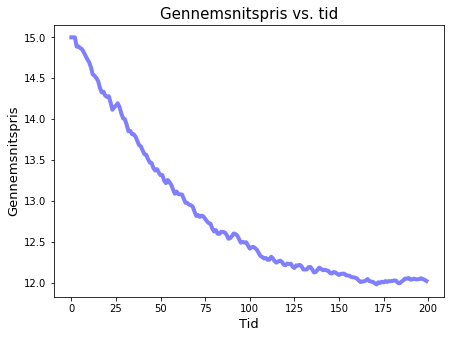

In [9]:
mean_prices.plot(legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
plt.title("Gennemsnitspris vs. tid", weight = 'roman', size = 15)
plt.xlabel('Tid', weight = 'roman', size = 13)
plt.ylabel('Gennemsnitspris', weight = 'roman', size = 13);

## Kør simulationen - og gem flere informationer

Kør simulationen igen, denne gang gemmer vi meget mere information, for at kunne plotte de enkelte agenters opførsel

In [10]:
# Opret tabeller til at gemme hver agents pris/produktion/profit, som
# vi kan bruge når vi skal lave grafer
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])

mean_productions[0:t_prehist] = initial_production_avg
mean_prices[0:t_prehist] = initial_price_avg
mean_profits[0:t_prehist] = 0

agents = create_agents(num_agents)
    
for t in range(3, time_steps):
    # Kør simulering
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])

    # Aflæs produktion og profit fra agenter
    quantities_t = [a.quantity for a in agents]
    profits_t = [a.profit for a in agents]

    # Beregn gennemsnitlig produktion og profit
    mean_production_t = np.nanmean(quantities_t)
    mean_profit_t = np.nanmean(profits_t)
    
    # Gem agenters profit, priser og produktionsmængder til plots
    profit_df.loc[t] = profits_t
    price_df.loc[t] = prices_t
    quantity_df.loc[t] = quantities_t

    mean_productions.iloc[t] = mean_production_t
    mean_prices.iloc[t] = mean_price_t
    mean_profits.iloc[t] = mean_profit_t
        
    #print(f"{t}: Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

## Plot kurver for hver enkelt agent

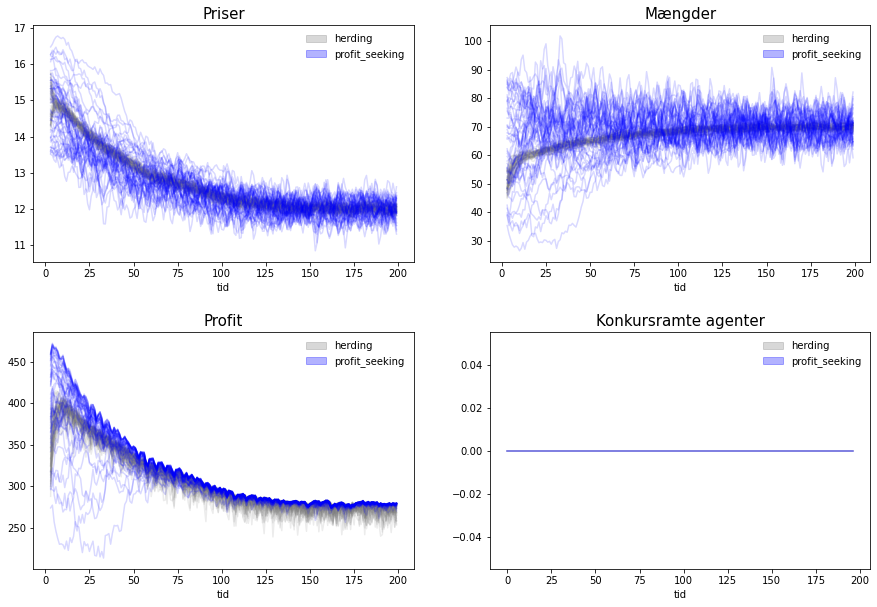

In [11]:
# Definer farver i plots
type_colors = {'herding': 'grey', 'profit_seeking': 'blue'}
agent_types = ['herding', 'profit_seeking']

# Kreer liste af farver i legend 
lpatch = []
for t in agent_types:
    lpatch.append(matplotlib.patches.Patch(color=type_colors[t], alpha = 0.3, label=t))

# Initier subplots og sæt figurstørrelse
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.set_size_inches(15, 10)

# Figur for individuelle priser 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    if idx:
        price_df.iloc[:,idx].plot(ax = axes[0,0], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[0, 0].set_title('Priser', weight = 'roman', size = 15);
# axes[0, 0].set_ylim(9,15)
axes[0, 0].set_xlabel('tid');
axes[0, 0].legend(handles = lpatch, loc = 1, frameon = False);

# Figur for individuelle produktionsmængder 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    if idx:
        quantity_df.iloc[:,idx].plot(ax = axes[0,1], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[0, 1].set_title('Mængder', weight = 'roman', size = 15);
# axes[0, 1].set_ylim(9,15)
axes[0, 1].set_xlabel('tid');
axes[0, 1].legend(handles = lpatch, loc = 1, frameon = False);


# Figur for individuel profit 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    if idx:
        profit_df.iloc[:,idx].plot(ax = axes[1,0], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[1, 0].set_title('Profit', weight = 'roman', size = 15);
# axes[1, 0].set_ylim(9,15)
axes[1, 0].set_xlabel('tid');
axes[1, 0].legend(handles = lpatch, loc = 1, frameon = False);


# Figur med andel overlevende agenter
for t in agent_types:
    df = price_df.iloc[t_prehist:,p_params[p_params['agent_type'] == t].index.tolist()]
    n_bankruptcies = df.isna().sum(axis=1)
    plt.plot(range(len(n_bankruptcies)), n_bankruptcies,  color = type_colors[t], alpha = 0.50)

axes[1, 1].set_title('Konkursramte agenter', weight = 'roman', size = 15);
# axes[1, 0].set_ylim(9,15)
axes[1, 1].set_xlabel('tid');
axes[1, 1].legend(handles = lpatch, loc = 1, frameon = False);

# Markedsligevægt
## Gentag hele simulationen flere gange og registrer gennemsnitlige slutværdier

In [12]:
##### Antal gentagelser
repetitions = 5

cols = ["r" + str(i) for i in range(repetitions)]
mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions[0:3] = initial_production_avg
mean_prices[0:3] = initial_price_avg
mean_profits[0:3] = 0

print("MARKEDSLIGEVÆGT (såfremt simulationen har stabiliseret sig - tjek graferne!)")
print("Observeret gennemsnitspris, mængde og profit ved slutningen af gentagne kørsler af hele simulationen")

for r in range(repetitions):
    agents = create_agents(num_agents)
    
    for t in range(3, time_steps):
        prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,r])

        # Aflæs produktion og profit fra agenter
        #quantities_t = marketlib.get_attr(agents, "quantity")
        #profits_t = marketlib.get_attr(agents, "profit")
        quantities_t = [a.quantity for a in agents]
        profits_t = [a.profit for a in agents]
    
        # Beregn gennemsnitlig produktion og profit
        mean_production_t = np.nanmean(quantities_t)
        mean_profit_t = np.nanmean(profits_t)
        
        # Gem data til plots
        mean_productions.iloc[t,r] = mean_production_t
        mean_prices.iloc[t,r] = mean_price_t
        mean_profits.iloc[t,r] = mean_profit_t
    
  
    print(f"{r}:   Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}  -  Mean profits: {mean_profit_t:.2f}")

MARKEDSLIGEVÆGT (såfremt simulationen har stabiliseret sig - tjek graferne!)
Observeret gennemsnitspris, mængde og profit ved slutningen af gentagne kørsler af hele simulationen
0:   Mean price: 12.05  -  Mean production: 69.81  -  Mean profits: 278.02
1:   Mean price: 12.07  -  Mean production: 69.79  -  Mean profits: 278.31
2:   Mean price: 12.08  -  Mean production: 69.56  -  Mean profits: 280.48
3:   Mean price: 12.03  -  Mean production: 69.77  -  Mean profits: 276.53
4:   Mean price: 11.99  -  Mean production: 70.57  -  Mean profits: 271.41
